<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17237921632643618872
xla_global_id: -1
]


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tf_keras

from keras import layers
from keras import models
from keras import regularizers
from keras import callbacks
from keras import initializers
from keras.layers import BatchNormalization
from keras.models import load_model

In [ ]:
num_classes = 10

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
np.transpose(y_train).shape

(60000,)

In [ ]:
y_train.shape

(60000,)

In [ ]:
def drow_hist(data):
  plt.figure(figsize=(8,6), dpi= 80)
  _ = plt.hist(data,
              bins=num_classes,
              stacked=True,
              density=False,
              range=(0,10),
              rwidth=0.9,
              )

In [ ]:
# create validation data
val_size = 6600

x_val = x_train[-val_size:, :, :]
x_train = x_train[:-val_size, :, :]

y_val = y_train[-val_size:]
y_train = y_train[:-val_size]

In [ ]:
# mirror train image
x_train_add = np.rot90(x_train, k=1, axes=(1,2))
x_train_add = np.transpose(x_train_add, (0, 2, 1))

In [ ]:
y_train_add = y_train.copy()

In [ ]:
# remove boots image from addition data [5, 7, 9]
for i in [5, 7, 9]:
    index = np.where(y_train_add == i )
    x_train_add = np.delete(x_train_add, index , axis=0)
    y_train_add = np.delete(y_train_add, index , axis=0)

In [ ]:
x_train_add.shape

(34972, 28, 28)

In [ ]:
y_train_add.shape

(34972,)

In [ ]:
# x_train = np.concatenate([
#     x_train,
#     x_train_add[:10000:, :, :]
# ])

In [ ]:
# y_train = np.concatenate([
#     y_train,
#     y_train_add[:10000]
# ])

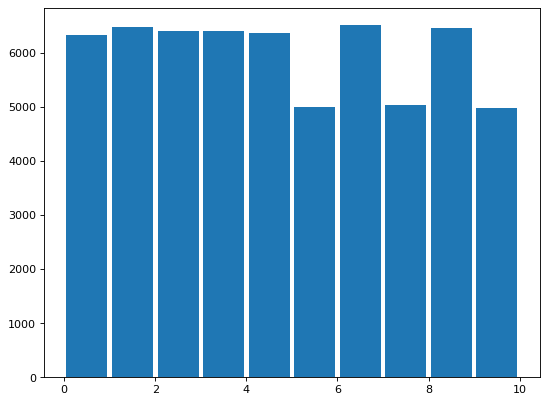

In [ ]:
drow_hist(y_train)

In [ ]:
# plt.figure()
# plt.imshow(x_train[7])
# plt.colorbar()
# plt.grid(False)
# plt.show()

In [ ]:
# plt.figure()
# plt.imshow(x_train_add[0])
# plt.colorbar()
# plt.grid(False)
# plt.show()

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

x_val = x_val.astype('float32') / 255
y_val = y_val.astype('float32')

In [ ]:
# class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# plt.figure(figsize=(10,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(x_train[i+50000], cmap=plt.cm.binary)
#     plt.xlabel(class_names[int(y_train[i+50000])])
# plt.show()

In [ ]:
# plt.figure(figsize=(10,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(x_train[i], cmap=plt.cm.binary)
#     plt.xlabel(class_names[int(y_train[i])])
# plt.show()

In [ ]:
w_init_tanh = initializers.glorot_normal(seed=111)
w_init_relu = initializers.HeNormal(seed=66)
# w_init_relu = initializers.HeUniform(seed=24)
b_init = initializers.Zeros()

In [ ]:
drop_out = 0.28

In [ ]:
def layer_relu(model, neurons):
  model.add(BatchNormalization())
  model.add(layers.Dense(neurons,
                       activation='relu',
                       kernel_initializer=w_init_relu,
                       bias_initializer=b_init))
  model.add(layers.Dropout(drop_out))
  return model

In [ ]:
def layer_tanh(model, neurons):
  model.add(BatchNormalization())
  model.add(layers.Dense(neurons,
                        activation='tanh',
                        kernel_initializer=w_init_tanh,
                        bias_initializer=b_init))
  model.add(layers.Dropout(drop_out))
  return model

In [ ]:
model = models.Sequential()

neurons = 256

model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dropout(drop_out))

model = layer_relu(model, neurons*1)
model = layer_tanh(model, neurons*2)
model = layer_relu(model, neurons*2)
# model = layer_relu(model, neurons*1)


model.add(layers.Dense(10, activation='softmax'))

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0003,
                                      beta_1=0.9,
                                      beta_2=0.999,
                                      epsilon=1e-06
)
# optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate=0.0005,
#                                                     rho=0.5,
#                                                     momentum=-16,
#                                                     epsilon=1e-07,
#                                                     centered=False,
#                                                     weight_decay=None,
#                                                     clipnorm=None,
#                                                     clipvalue=None,
#                                                     global_clipnorm=None,
#                                                     use_ema=False,
#                                                     ema_momentum=0.99,
#                                                     ema_overwrite_frequency=100,
#                                                     jit_compile=True,
#                                                     name='RMSprop',
# )

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
model.compile(#optimizer='adam',
              # optimizer='adamax',
              optimizer=optimizer,
              # optimizer='rmsprop',
              # optimizer='sgd',
              # optimizer='adadelta',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy']) # sparse_categorical_accuracy

In [ ]:
# callback = callbacks.EarlyStopping(monitor='val_loss',
#                                    patience=15,
#                                    restore_best_weights=True,
#                                    )
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=15)
mc = callbacks.ModelCheckpoint('best_model.h5', monitor='sparse_categorical_accuracy', mode='max', verbose=0, save_best_only=True)


In [ ]:
history = model.fit(x_train, y_train,
                    epochs=300,
                    batch_size=128,
                    # callbacks=[callback],
                    callbacks=[mc],
                    verbose=1, #многословие
                    # validation_split=0.2
                    validation_data=(x_val, y_val)
                    )
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/400
418/418 [==============================] - 15s 27ms/step - loss: 0.8770 - sparse_categorical_accuracy: 0.6962 - val_loss: 0.4738 - val_sparse_categorical_accuracy: 0.8221
Epoch 2/400
418/418 [==============================] - 11s 26ms/step - loss: 0.6112 - sparse_categorical_accuracy: 0.7804 - val_loss: 0.4143 - val_sparse_categorical_accuracy: 0.8430
Epoch 3/400
418/418 [==============================] - 10s 25ms/step - loss: 0.5417 - sparse_categorical_accuracy: 0.8048 - val_loss: 0.3984 - val_sparse_categorical_accuracy: 0.8505
Epoch 4/400
418/418 [==============================] - 11s 26ms/step - loss: 0.4997 - sparse_categorical_accuracy: 0.8165 - val_loss: 0.3832 - val_sparse_categorical_accuracy: 0.8564
Epoch 5/400
418/418 [==============================] - 12s 29ms/step - loss: 0.4673 - sparse_categorical_accuracy: 0.8283 - val_loss: 0.3771 - val_sparse_categorical_accuracy: 0.8605
Epoch 6/400
418/418 [==============================] - 11s 27ms/step - loss: 0.4467 -

In [ ]:
print('\nhistory dict:', list(history.history.keys()))


history dict: ['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy']


In [ ]:
result = model.evaluate(x_test, y_test)
print(result)

313/313 [==============================] - 1s 3ms/step - loss: 0.3018 - sparse_categorical_accuracy: 0.9004
[0.30175644159317017, 0.9003999829292297]


In [ ]:
saved_model = load_model('best_model.h5')
result = saved_model.evaluate(x_test, y_test)
print(result)

313/313 [==============================] - 1s 3ms/step - loss: 0.3038 - sparse_categorical_accuracy: 0.8976
[0.3037850260734558, 0.897599995136261]


In [ ]:
# from keras.models import load_model
# saved_model = load_model('best_model.h5')
# # _, train_acc = saved_model.evaluate(x_train, y_train, verbose=0)
# _, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
# print('Test: %.3f' % (test_acc))

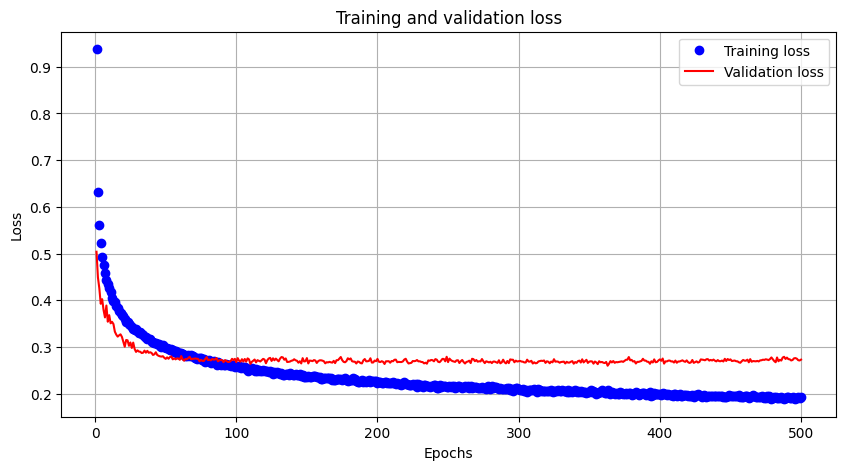

<Figure size 640x480 with 0 Axes>

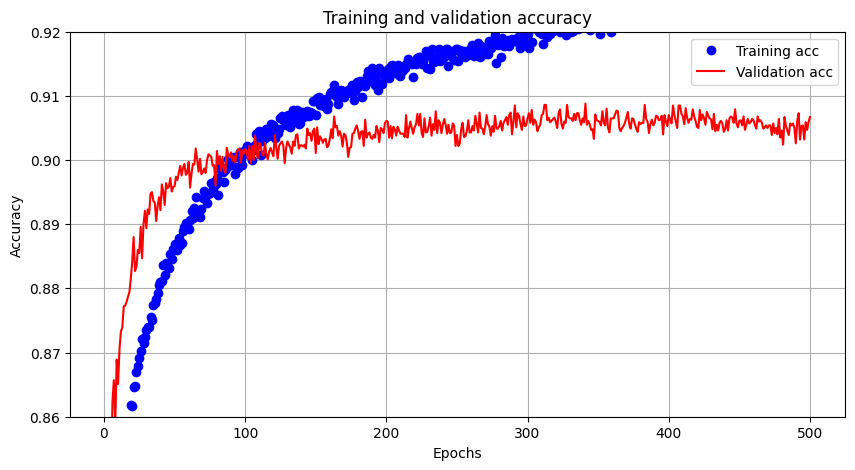

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
# plt.ylim (0.2, 0.5)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
1
plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['sparse_categorical_accuracy']
plt.plot(epochs, history_dict['sparse_categorical_accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_sparse_categorical_accuracy'], 'r', label='Validation acc')
plt.ylim (0.86, 0.92)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [ ]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [ ]:
predictions[0]

array([0.08534302, 0.08534302, 0.08534302, 0.08534302, 0.08534302,
       0.08534329, 0.08534302, 0.08538555, 0.08534302, 0.23187007],
      dtype=float32)

In [ ]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 784)               0         
                                                                 
 dropout_44 (Dropout)        (None, 784)               0         
                                                                 
 batch_normalization_33 (Ba  (None, 784)               3136      
 tchNormalization)                                               
                                                                 
 dense_44 (Dense)            (None, 256)               200960    
                                                                 
 dropout_45 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_34 (Ba  (None, 256)               1024      
 tchNormalization)                                   

In [ ]:


hnyetjn hrte()

SyntaxError: invalid syntax (<ipython-input-481-1a3818e70946>, line 1)